## Test modules during dev


In [1]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [3]:
import sys
sys.path.append('./modules/')

In [4]:
%reload_ext autoreload
%autoreload 2
import datasets

In [5]:
dtree = datasets.read_filtered_datatree()

In [6]:
dtree = datasets.calculate_magnitudes(dtree)

In [64]:
DT = datasets.MLDataset(simulation_names=['P2L', 'DG'], filter_scales=['50','100'])
DT.simulation_data = DT.simulation_data.isel(Time=slice(-20, None))

In [65]:
DT.default_preprocess_pipeline(window_size=3)

In [66]:
ds = DT.ml_input_dataset['P2L']['100'].ds

In [67]:
frame_vector_vars = ['dhdx','dhdy']
frame_vector_vars[0]

'dhdx'

In [68]:
mag_frame_vector = (ds[frame_vector_vars[0]]**2 + ds[frame_vector_vars[1]]**2)**0.5

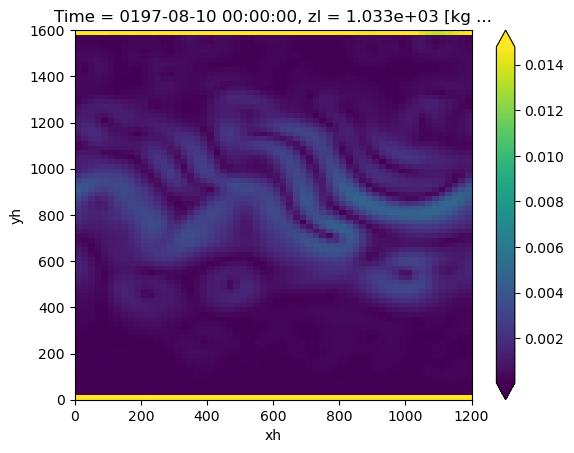

In [69]:
mag_frame_vector.isel(Time=0, zl=1).plot(robust=True)

In [70]:
T_hat_i = ds[frame_vector_vars[0]]/mag_frame_vector
T_hat_j = ds[frame_vector_vars[1]]/mag_frame_vector

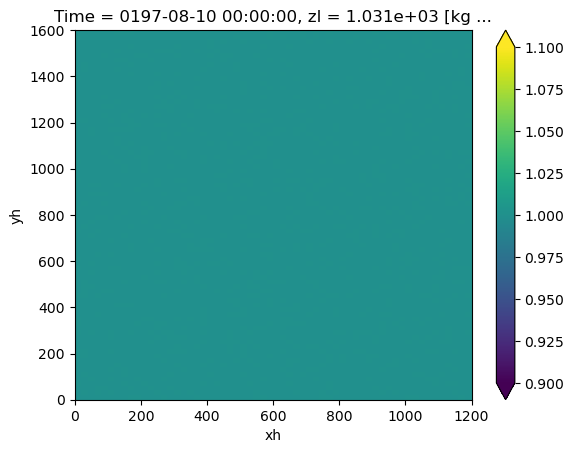

In [71]:
(T_hat_i**2 + T_hat_j**2).isel(Time=0, zl=0).plot(robust=True)

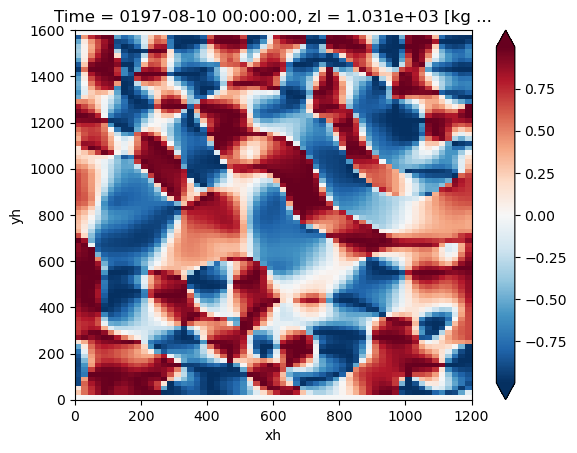

In [72]:
T_hat_i.isel(Time=0, zl=0).plot(robust=True)

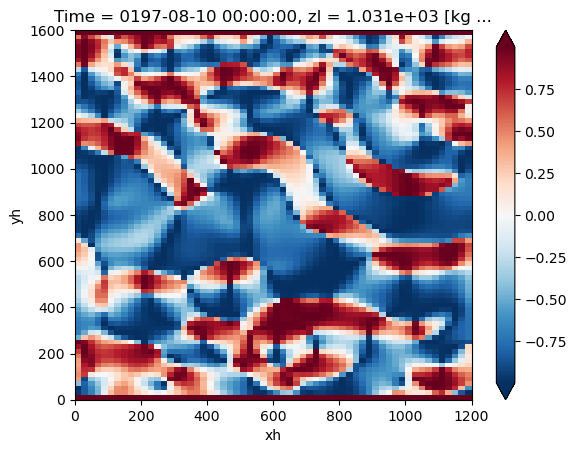

In [73]:
T_hat_j.isel(Time=0, zl=0).plot(robust=True)

In [74]:
N_hat_i = - T_hat_j
N_hat_j = T_hat_i

In [75]:
R_11 = T_hat_i
R_12 = N_hat_i
R_21 = T_hat_j
R_22 = N_hat_j

In [76]:
vec_var = frame_vector_vars

In [77]:
def rotate_vector(R_11, R_12, R_21, R_22, F_1, F_2): 
    vec_That = R_11 * F_1 + R_21 * F_2
    vec_Nhat = R_12 * F_1 + R_22 * F_2

    return vec_That, vec_Nhat


In [86]:
def two_by_two_matrix_multiplication(A_11, A_12, A_21, A_22, B_11, B_12, B_21, B_22): 
    '''
    A simple matrix multiplication of two 2X2 matrices.
    '''
    C_11 = A_11*B_11 + A_12*B_21
    C_12 = A_11*B_12 + A_12*B_22
    C_21 = A_21*B_11 + A_22*B_21
    C_22 = A_21*B_12 + A_22*B_22
    return C_11, C_12, C_21, C_22

In [87]:
def rotate_tensor(R_11, R_12, R_21, R_22, T_11, T_12, T_21, T_22): 
    '''
    Rotate tensor = R_transpose (T) R
    '''
    
    # C = R_transpose (T)
    C_11, C_12, C_21, C_22 = two_by_two_matrix_multiplication(R_11, R_21, R_12, R_22, T_11, T_12, T_21, T_22)

    # Tp = C R, where Tp is the rotated tensor
    Tp_11, Tp_12, Tp_21, Tp_22 = two_by_two_matrix_multiplication(C_11, C_12, C_21, C_22, R_11, R_12, R_21, R_22)

    return Tp_11, Tp_12, Tp_21, Tp_22

In [88]:
Tp_11, Tp_12, Tp_21, Tp_22 = rotate_tensor(R_11, R_12, R_21, R_22,
                                           ds['dudx'], ds['dudy'],
                                           ds['dvdx'], ds['dvdy'])

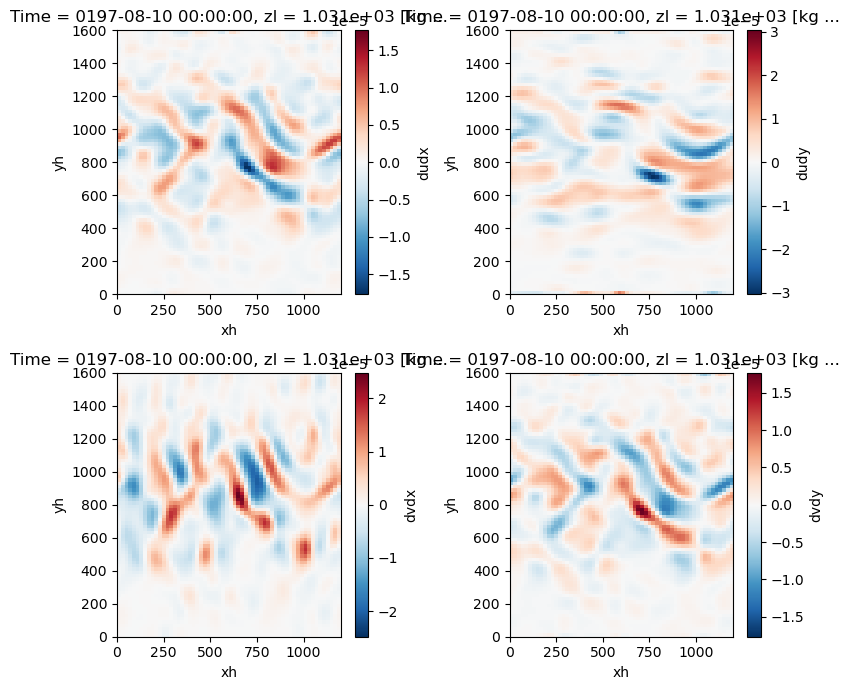

In [92]:
plt.figure(figsize=(8,7))

plt.subplot(221)
ds['dudx'].isel(Time=0, zl=0).plot()

plt.subplot(222)
ds['dudy'].isel(Time=0, zl=0).plot()

plt.subplot(223)
ds['dvdx'].isel(Time=0, zl=0).plot()

plt.subplot(224)
ds['dvdy'].isel(Time=0, zl=0).plot()

plt.tight_layout()

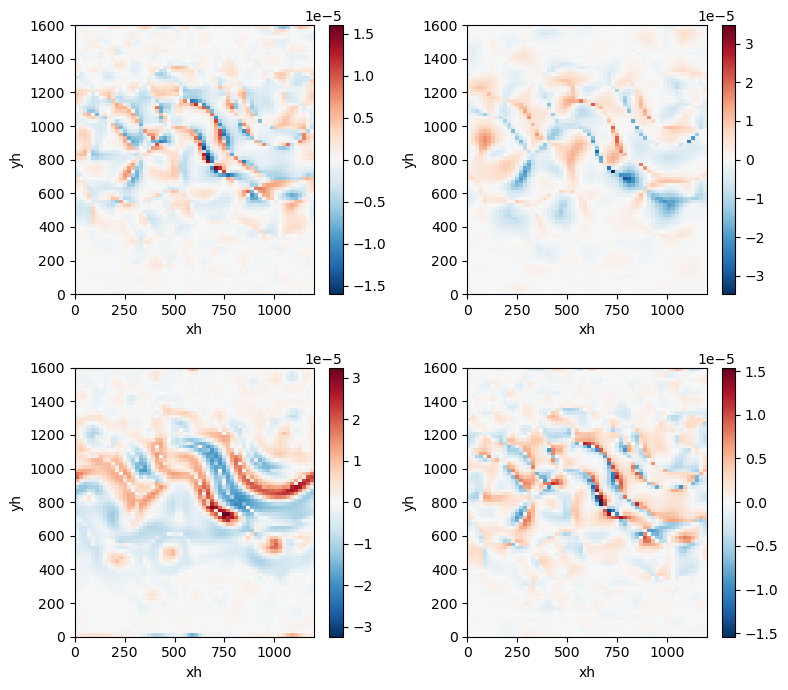

In [95]:
plt.figure(figsize=(8,7))
zl = 0
plt.subplot(221)
Tp_11.isel(Time=0, zl=zl).plot()
plt.title('')

plt.subplot(222)
Tp_12.isel(Time=0, zl=zl).plot()
plt.title('')

plt.subplot(223)
Tp_21.isel(Time=0, zl=zl).plot()
plt.title('')

plt.subplot(224)
Tp_22.isel(Time=0, zl=zl).plot()
plt.title('')

plt.tight_layout()

In [79]:
#vec_That = R_11 * ds[vec_var[0]] + R_21 * ds[vec_var[1]]
#vec_Nhat = R_12 * ds[vec_var[0]] + R_22 * ds[vec_var[1]]

vec_That, vec_Nhat = rotate_vector(R_11, R_12, R_21, R_22, ds['dhdx_widened'], ds['dhdy_widened'])

In [80]:
vec_That

<xarray.DataArray (Time: 20, zl: 2, yh: 80, xh: 60, Xn: 3, Yn: 3)> Size: 14MB
dask.array<add, shape=(20, 2, 80, 60, 3, 3), dtype=float64, chunksize=(20, 2, 79, 59, 3, 3), chunktype=numpy.ndarray>
Coordinates:
  * Time     (Time) object 160B 0197-08-10 00:00:00 ... 0198-02-16 00:00:00
  * xh       (xh) float64 480B 10.0 30.0 50.0 ... 1.15e+03 1.17e+03 1.19e+03
  * yh       (yh) float64 640B 10.0 30.0 50.0 ... 1.55e+03 1.57e+03 1.59e+03
  * zl       (zl) float64 16B 1.031e+03 1.033e+03
Dimensions without coordinates: Xn, Yn

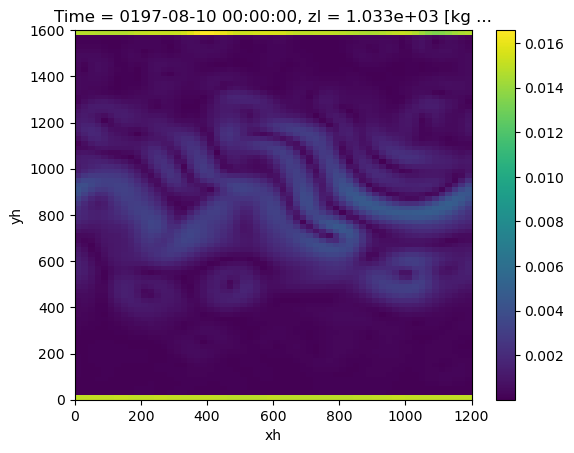

In [81]:
vec_That.isel(Time=0, zl=1, Xn=1, Yn=1).plot()

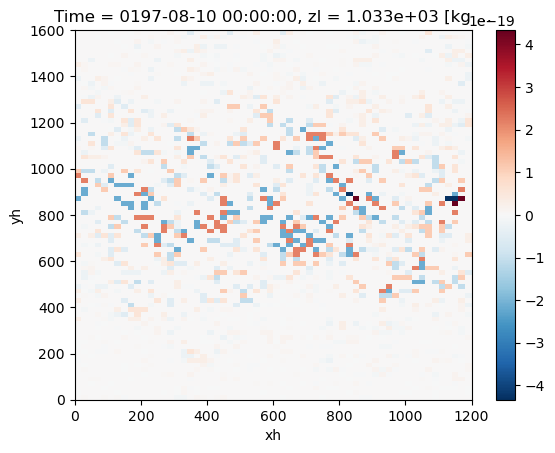

In [82]:
vec_Nhat.isel(Time=0, zl=1, Xn=1, Yn=1).plot()

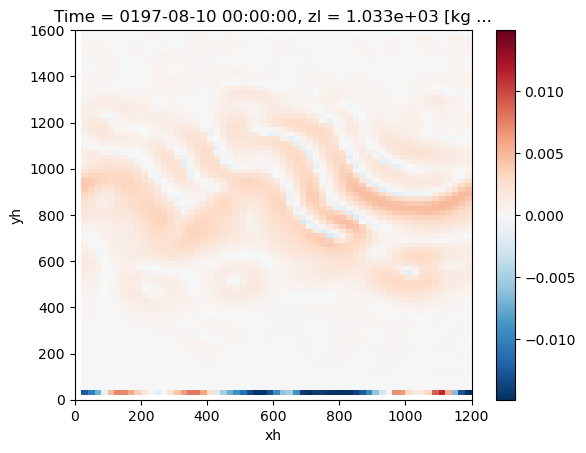

In [84]:
vec_That.isel(Time=0, zl=1, Xn=0, Yn=0).plot()

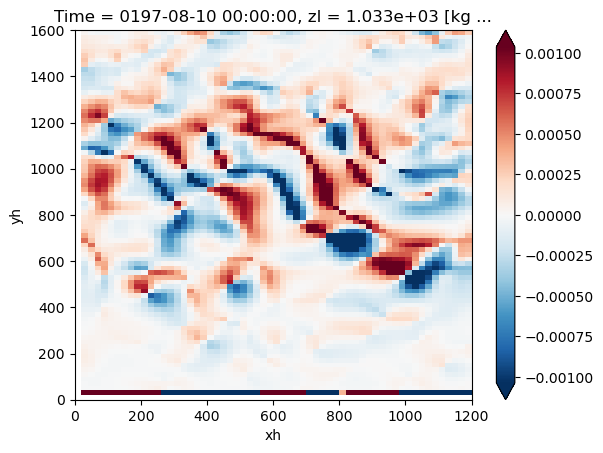

In [85]:
vec_Nhat.isel(Time=0, zl=1, Xn=0, Yn=0).plot(robust=True)